# DIC Crack Inspector

In [1]:
#%matplotlib widget

In [2]:
from bmcs_shear.dic_crack import DICGrid, DICAlignedGrid, DICCOR, DICInspector, DICCrack

Convenience function to construct cracks

In [3]:
def construct_dic_cracks(cracks):
    '''Use the supplied list of crack specifications to construct the DICCrack objects'''
    dic_cracks = []
    for i, (ref_frame, rot_grid) in enumerate(cracks):
        dic_aligned_grid = DICAlignedGrid(dic_grid=dic_grid)
        dic_aligned_grid.trait_set(**ref_frame)
        dic_cor = DICCOR(dic_aligned_grid=dic_aligned_grid)
        dic_cor.trait_set(**rot_grid)
        dic_crack = DICCrack(name='crack #%d' % (i+1), dic_cor=dic_cor)
        dic_cracks.append(dic_crack)
    return dic_cracks

# B1_TV1

In [4]:
B1_TV1_cracks = [
    # crack 1
    (dict(y_ref_i=-1, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -7, n_x_max = -6, n_x_step=1, n_y_min = 1, n_y_max=-2, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-7, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -13, n_x_max = -10, n_x_step=1, n_y_min = 1, n_y_max=-1, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-11, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -20, n_x_max = -17, n_x_step=1, n_y_min = 1, n_y_max=7, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-20, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = 29, n_x_max = 37, n_x_step=1, n_y_min = 7, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=-28, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-35, n_x_max=-32, n_x_step=1, n_y_min = 2, n_y_max=12, n_y_step = 1)),
    # crack 6
    (dict(y_ref_i=-33, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-46, n_x_max=-39, n_x_step=2, n_y_min = 6, n_y_max=-1, n_y_step = 2)),
    # crack 7
    (dict(y_ref_i=13, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=1, n_x_max=8, n_x_step=2, n_y_min = 2, n_y_max=10, n_y_step = 2)),
]

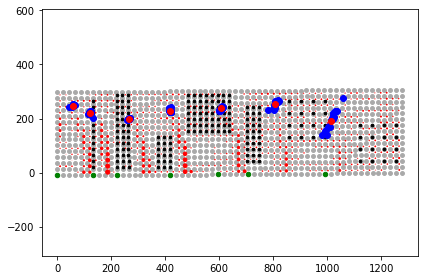

In [5]:
dic_grid = DICGrid(n_x=59, n_y=15, d_x = 22, d_y = 22,  start_t = 0, end_t =18, U_factor = 1, 
                   dir_name='B1_TV1', grid_column_first = False, grid_number_vertical = False)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B1_TV1_cracks)
dic_insp.interact()

In [6]:
dic_cor = dic_insp.dic_cracks.items[1].dic_cor

In [7]:
dic_cor.dic_aligned_grid.X_ref_a

AttributeError: 'DICAlignedGrid' object has no attribute 'X_ref_a'

In [ ]:
dic_cor.X_cor, dic_cor.X_cor_b

# B1_TV2

In [10]:
B1_TV2_cracks = [
    # crack 1
    (dict(y_ref_i=-1, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -7, n_x_max = -6, n_x_step=1, n_y_min = 1, n_y_max=-5, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-7, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -16, n_x_max = -12, n_x_step=1, n_y_min = 7, n_y_max=-1, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-23, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -31, n_x_max = -26, n_x_step=1, n_y_min = 1, n_y_max=7, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-31, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = 20, n_x_max = 24, n_x_step=1, n_y_min = 7, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=15, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=5, n_x_max=9, n_x_step=1, n_y_min = 7, n_y_max=12, n_y_step = 1)),
]

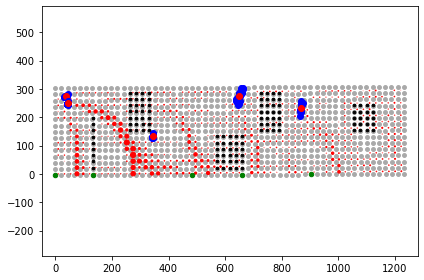

In [11]:
dic_grid = DICGrid(n_x=57, n_y=15, d_x = 22, d_y = 22,  start_t = 0, end_t =18, U_factor = 1, 
                   dir_name='B1_TV2', grid_column_first = False, grid_number_vertical = False)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B1_TV2_cracks)
dic_insp.interact()

# B5_TV1

In [12]:
B5_TV1_cracks = [
    # crack 1
    (dict(y_ref_i=-1, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -7, n_x_max = -6, n_x_step=1, n_y_min = 1, n_y_max=-5, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-7, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -12, n_x_max = -11, n_x_step=1, n_y_min = 1, n_y_max=-5, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-12, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -18, n_x_max = -16, n_x_step=1, n_y_min = 1, n_y_max=7, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-18, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -23, n_x_max = -21, n_x_step=1, n_y_min = 5, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=-23, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-30, n_x_max=-27, n_x_step=1, n_y_min = 1, n_y_max=8, n_y_step = 1)),
    # crack 6
    (dict(y_ref_i=-30, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-37, n_x_max=-34, n_x_step=1, n_y_min = 1, n_y_max=8, n_y_step = 1)),
    # crack 7
    (dict(y_ref_i=-37, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-46, n_x_max=-42, n_x_step=1, n_y_min = 5, n_y_max=12, n_y_step = 1)),
    # crack 8
    (dict(y_ref_i=-44, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-52, n_x_max=-50, n_x_step=1, n_y_min = 5, n_y_max=12, n_y_step = 1)),
    # crack 9
    (dict(y_ref_i=-52, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-64, n_x_max=-58, n_x_step=1, n_y_min = 1, n_y_max=9, n_y_step = 1)),
]

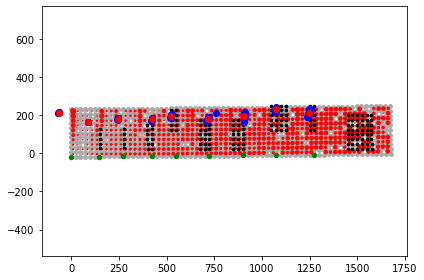

In [13]:
dic_grid = DICGrid(n_x=68, n_y=11, d_x = 25, d_y = 25,  start_t = 0, end_t =23, U_factor = 1, 
                   dir_name='B5_TV1', grid_column_first = True, grid_number_vertical = True)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B5_TV1_cracks)
dic_insp.interact()

# B5_TV2

In [14]:
B5_TV2_cracks = [
    # crack 1
    (dict(y_ref_i=-1, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -4, n_x_max = -3, n_x_step=1, n_y_min = 1, n_y_max=6, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-4, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -13, n_x_max = -11, n_x_step=1, n_y_min = 5, n_y_max=9, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-13, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -18, n_x_max = -16, n_x_step=1, n_y_min = 5, n_y_max=9, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-18, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -26, n_x_max = -23, n_x_step=1, n_y_min = 5, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=-26, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-31, n_x_max=-28, n_x_step=1, n_y_min = 3, n_y_max=10, n_y_step = 1)),
    # crack 6
    (dict(y_ref_i=-31, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-37, n_x_max=-35, n_x_step=1, n_y_min = 4, n_y_max=11, n_y_step = 1)),
    # crack 7
    (dict(y_ref_i=-37, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-46, n_x_max=-42, n_x_step=1, n_y_min = 5, n_y_max=10, n_y_step = 1)),
    # crack 8
    (dict(y_ref_i=-46, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-51, n_x_max=-48, n_x_step=1, n_y_min = 5, n_y_max=10, n_y_step = 1)),
    # crack 9
    (dict(y_ref_i=-52, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-64, n_x_max=-58, n_x_step=1, n_y_min = 2, n_y_max=9, n_y_step = 1)),
]

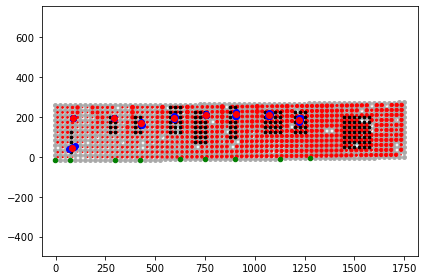

In [15]:
dic_grid = DICGrid(n_x=71, n_y=12, d_x = 25, d_y = 25,  start_t = 0, end_t =20, U_factor = 1, 
                   dir_name='B5_TV2', grid_column_first = True, grid_number_vertical = True)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B5_TV2_cracks)
dic_insp.interact()

# B6_TV1

In [15]:
B6_TV1_cracks = [
    # crask 1
    (dict(y_ref_i=-1, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -10, n_x_max = -9, n_x_step=1, n_y_min = 1, n_y_max=10, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-10, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -16, n_x_max = -13, n_x_step=1, n_y_min = 1, n_y_max=10, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-15, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -20, n_x_max = -18, n_x_step=1, n_y_min = 1, n_y_max=7, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-21, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -29, n_x_max = -23, n_x_step=1, n_y_min = 4, n_y_max=-1, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=31, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = 21, n_x_max = 26, n_x_step=1, n_y_min =3, n_y_max=-1, n_y_step = 1)),
    # crack 6
    (dict(y_ref_i=22, y_ref_j_min=1, y_ref_j_max=10),#22
     dict(n_x_min = 1, n_x_max = 14, n_x_step=2, n_y_min = 3, n_y_max=-3, n_y_step = 2))
]

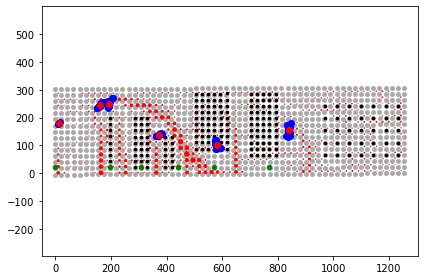

In [16]:
dic_grid = DICGrid(n_x=58, n_y=15, d_x = 22, d_y = 22, start_t = 0, end_t =24, U_factor = 1, 
                   dir_name='B6_TV1', grid_column_first = False, grid_number_vertical = False)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B6_TV1_cracks)
dic_insp.interact()

# B6_TV2

In [17]:
B6_TV2_cracks = [
    # crask 1
    (dict(y_ref_i=-1, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -7, n_x_max = -4, n_x_step=1, n_y_min = 1, n_y_max=10, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-7, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -15, n_x_max = -12, n_x_step=1, n_y_min = 5, n_y_max=12, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-15, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -25, n_x_max = -21, n_x_step=1, n_y_min = 7, n_y_max=12, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=20, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = 1, n_x_max = 14, n_x_step=1, n_y_min = 1, n_y_max=-1, n_y_step = 1)),
#     # crack 5
#     (dict(y_ref_i=31, y_ref_j_min=1, y_ref_j_max=10),
#      dict(n_x_min = 21, n_x_max = 26, n_x_step=1, n_y_min =3, n_y_max=-1, n_y_step = 1)),
#     # crack 6
#     (dict(y_ref_i=22, y_ref_j_min=1, y_ref_j_max=10),#22
#      dict(n_x_min = 1, n_x_max = 14, n_x_step=2, n_y_min = 3, n_y_max=-3, n_y_step = 2))
]

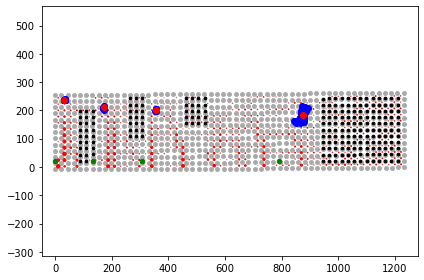

In [18]:
dic_grid = DICGrid(n_x=57, n_y=13, d_x = 22, d_y = 22, start_t = 0, end_t =-3, U_factor = 1, 
                   dir_name='B6_TV2_', grid_column_first = False, grid_number_vertical = False)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B6_TV2_cracks)
dic_insp.interact()

# B7_TV1

In [19]:
B7_TV1_cracks = [
    # crask 1
    (dict(y_ref_i=-1, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -12, n_x_max = -8, n_x_step=1, n_y_min = 1, n_y_max=10, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-12, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -19, n_x_max = -16, n_x_step=1, n_y_min = 1, n_y_max=10, n_y_step = 1)),
     # crack 3
     (dict(y_ref_i=-19, y_ref_j_min=1, y_ref_j_max=10),
      dict(n_x_min = 32, n_x_max = 35, n_x_step=1, n_y_min = 1, n_y_max=8, n_y_step = 1)),
     # crack 4
     (dict(y_ref_i=32, y_ref_j_min=1, y_ref_j_max=10),
      dict(n_x_min = 23, n_x_max = 26, n_x_step=1, n_y_min = 1, n_y_max=7, n_y_step = 1)),
     # crack 5
     (dict(y_ref_i=25, y_ref_j_min=1, y_ref_j_max=10),
      dict(n_x_min = 0, n_x_max = 18, n_x_step=2, n_y_min = 1, n_y_max=-1, n_y_step = 2)),
]

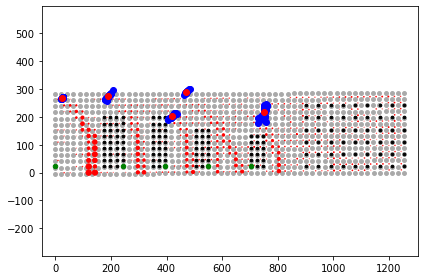

In [20]:
dic_grid = DICGrid(n_x=58, n_y=14, d_x = 22, d_y = 22, start_t = 0, end_t =17, U_factor = 1, 
                   dir_name='B7_TV1', grid_column_first = False, grid_number_vertical = False)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B7_TV1_cracks)
dic_insp.interact()

# B7_TV2

In [21]:
B7_TV2_cracks = [
    # crask 1
    (dict(y_ref_i=-1, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -8, n_x_max = -6, n_x_step=1, n_y_min = 1, n_y_max=10, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-8, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -13, n_x_max = -11, n_x_step=1, n_y_min = 1, n_y_max=10, n_y_step = 1)),
     # crack 3
     (dict(y_ref_i=-13, y_ref_j_min=1, y_ref_j_max=10),
      dict(n_x_min = -23, n_x_max = -18, n_x_step=1, n_y_min = 3, n_y_max=8, n_y_step = 1)),
     # crack 4
     (dict(y_ref_i=-23, y_ref_j_min=1, y_ref_j_max=10),
      dict(n_x_min = -28, n_x_max = -24, n_x_step=1, n_y_min = 3, n_y_max=7, n_y_step = 1)),
     # crack 5
     (dict(y_ref_i=-28, y_ref_j_min=1, y_ref_j_max=10),
      dict(n_x_min = 1, n_x_max = 12, n_x_step=1, n_y_min = 1, n_y_max=-1, n_y_step = 1)),
]

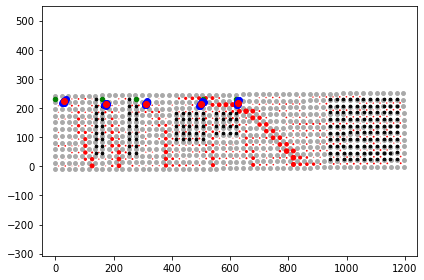

In [22]:
dic_grid = DICGrid(n_x=53, n_y=12, d_x = 23, d_y = 23, start_t = 0, end_t =15, U_factor = 1, 
                   dir_name='B7_TV2', grid_column_first = True, grid_number_vertical = True)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B7_TV2_cracks)
dic_insp.interact()

# B8_TV1

In [23]:
B8_TV1_cracks = [
    # crack 1
    (dict(y_ref_i=-1 , y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -15, n_x_max = -8, n_x_step=1, n_y_min = 5, n_y_max=-2, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-13, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -19, n_x_max = -17, n_x_step=1, n_y_min = 8, n_y_max=-1, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-19, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -24, n_x_max = -21, n_x_step=1, n_y_min = 5, n_y_max=-1, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-24, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -33, n_x_max = -29, n_x_step=1, n_y_min = 7, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=-33, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=1, n_x_max=15, n_x_step=1, n_y_min = 2, n_y_max=12, n_y_step = 1)),
]

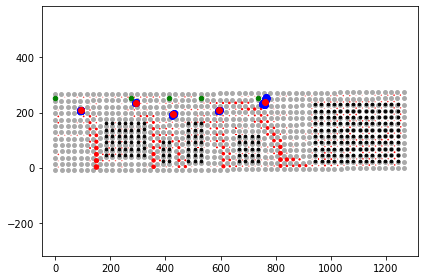

In [24]:
dic_grid = DICGrid(n_x=56, n_y=13, d_x = 23, d_y = 23,  start_t = 0, end_t =-1, U_factor = 1, 
                   dir_name='B8_TV1', grid_column_first = True, grid_number_vertical = True)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B8_TV1_cracks)
dic_insp.interact()

# B8_TV2

In [25]:
B8_TV2_cracks = [
    # crack 1
    (dict(y_ref_i=-1 , y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -8, n_x_max = -3, n_x_step=1, n_y_min = 5, n_y_max=-2, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-8, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -16, n_x_max = -13, n_x_step=1, n_y_min = 5, n_y_max=11, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-16, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -25, n_x_max = -21, n_x_step=1, n_y_min = 5, n_y_max=10, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-24, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -35, n_x_max = -31, n_x_step=1, n_y_min = 5, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=-33, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=1, n_x_max=14, n_x_step=1, n_y_min = 2, n_y_max=12, n_y_step = 1)),
]

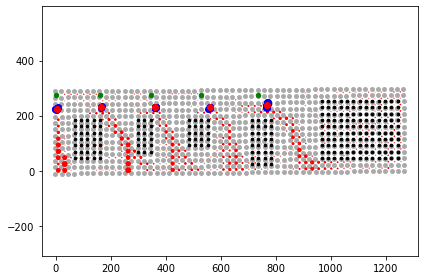

In [26]:
dic_grid = DICGrid(n_x=56, n_y=14, d_x = 23, d_y = 23,  start_t = 0, end_t =-1, U_factor = 1, 
                   dir_name='B8_TV2', grid_column_first = True, grid_number_vertical = True)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B8_TV2_cracks)
dic_insp.interact()

# B9_TV1

In [27]:
B9_TV1_cracks = [
    # crack 1
    (dict(y_ref_i=-1 , y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -9, n_x_max = -6, n_x_step=1, n_y_min = 5, n_y_max=-2, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-9, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -15, n_x_max = -12, n_x_step=1, n_y_min = 1, n_y_max=4, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-14, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -19, n_x_max = -16, n_x_step=1, n_y_min = 5, n_y_max=10, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-19, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -25, n_x_max = -22, n_x_step=1, n_y_min = 3, n_y_max = 8, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=-25, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-30, n_x_max=-28, n_x_step=1, n_y_min = 3, n_y_max=8, n_y_step = 1)),
    # crack 6
    (dict(y_ref_i=-30, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=1, n_x_max=14, n_x_step=1, n_y_min = 1, n_y_max=10, n_y_step = 1)),
]

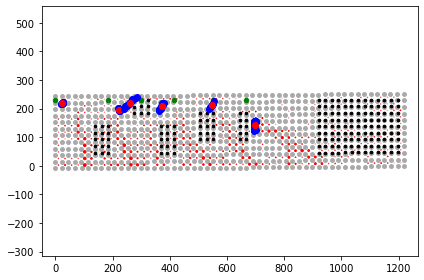

In [28]:
dic_grid = DICGrid(n_x=54, n_y=12, d_x = 23, d_y = 23, start_t = 0, end_t =-1, U_factor = 1, 
                   dir_name='B9_TV1_', grid_column_first = True, grid_number_vertical = True)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B9_TV1_cracks)
dic_insp.interact()

# B9_TV2

In [29]:
B9_TV2_cracks = [
    # crack 1
    (dict(y_ref_i=-1 , y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -9, n_x_max = -6, n_x_step=1, n_y_min = 5, n_y_max=-2, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-9, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -15, n_x_max = -11, n_x_step=1, n_y_min = 6, n_y_max=10, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-14, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -20, n_x_max = -17, n_x_step=1, n_y_min = 5, n_y_max=10, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-19, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -25, n_x_max = -22, n_x_step=1, n_y_min = 3, n_y_max = 8, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=-25, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-33, n_x_max=-30, n_x_step=1, n_y_min = 6, n_y_max=10, n_y_step = 1)),
    # crack 6
    (dict(y_ref_i=-33, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=1, n_x_max=14, n_x_step=1, n_y_min = 1, n_y_max=10, n_y_step = 1)),
]

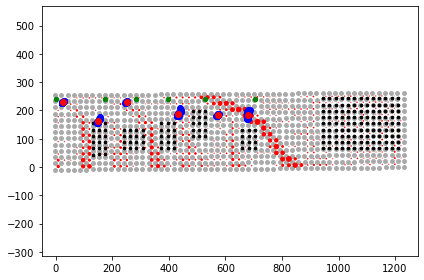

In [30]:
dic_grid = DICGrid(n_x=57, n_y=13, d_x = 22, d_y = 22, start_t = 0, end_t =-1, U_factor = 1, 
                   dir_name='B9_TV2', grid_column_first = True, grid_number_vertical = True)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B9_TV2_cracks)
dic_insp.interact()

# B10_TV1

In [31]:
B10_TV1_cracks = [
    # crack 1
    (dict(y_ref_i=-1 , y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -6, n_x_max = -3, n_x_step=1, n_y_min = 1, n_y_max=5, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-6, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -16, n_x_max = -13, n_x_step=1, n_y_min = 6, n_y_max=10, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-14, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -25, n_x_max = -22, n_x_step=1, n_y_min = 5, n_y_max=10, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-25, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -33, n_x_max = -28, n_x_step=1, n_y_min = 7, n_y_max = 12, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=-33, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=1, n_x_max=14, n_x_step=1, n_y_min = 1, n_y_max=12, n_y_step = 1)),
]

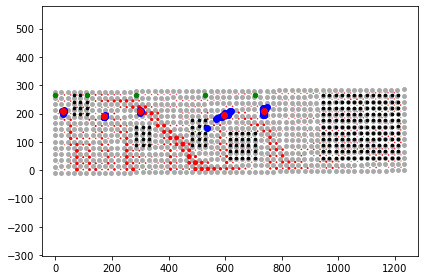

In [32]:
dic_grid = DICGrid(n_x=57, n_y=14, d_x = 22, d_y = 22, start_t = 0, end_t =-1, U_factor = 1, 
                   dir_name='B10_TV1', grid_column_first = True, grid_number_vertical = True)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B10_TV1_cracks)
dic_insp.interact()

# B10_TV2

In [33]:
B10_TV2_cracks = [
    # crack 1
    (dict(y_ref_i=-1 , y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -11, n_x_max = -8, n_x_step=1, n_y_min = 1, n_y_max=5, n_y_step = 1)),
    # crack 2
    (dict(y_ref_i=-11, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -16, n_x_max = -13, n_x_step=1, n_y_min = 1, n_y_max=4, n_y_step = 1)),
    # crack 3
    (dict(y_ref_i=-16, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -21, n_x_max = -18, n_x_step=1, n_y_min = 1, n_y_max=5, n_y_step = 1)),
    # crack 4
    (dict(y_ref_i=-21, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min = -29, n_x_max = -24, n_x_step=1, n_y_min = 1, n_y_max = 7, n_y_step = 1)),
    # crack 5
    (dict(y_ref_i=-29, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=-37, n_x_max=-33, n_x_step=1, n_y_min = 1, n_y_max=5, n_y_step = 1)),
     # crack 6
    (dict(y_ref_i=-37, y_ref_j_min=1, y_ref_j_max=10),
     dict(n_x_min=0, n_x_max=14, n_x_step=1, n_y_min = 1, n_y_max=10, n_y_step = 1)),
]

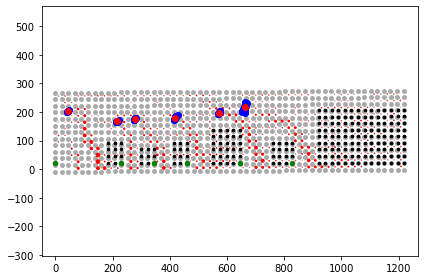

In [34]:
dic_grid = DICGrid(n_x=54, n_y=13, d_x = 23, d_y = 23, start_t = 0, end_t =-1, U_factor = 1, 
                   dir_name='B10_TV2', grid_column_first = False, grid_number_vertical = False)
dic_insp = DICInspector(dic_grid=dic_grid)
dic_insp.dic_cracks.items = construct_dic_cracks(B10_TV2_cracks)
dic_insp.interact()